In [3]:
!pip install numpy
!pip install h5py
!pip install glob2
!pip install matplotlib
!pip install scikit-learn
!pip install tensorflow[and-cuda]


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import os
import numpy as np
import h5py
import glob
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import backend as K

%matplotlib inline

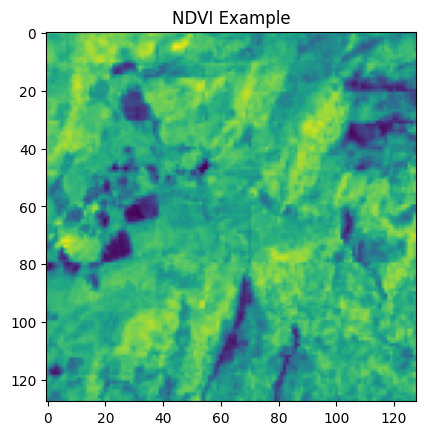

In [5]:
# Set dataset directory
os.chdir(r'D:\DATASET\archive (1)')

# Define paths
path_single = r"D:\DATASET\archive (1)\TrainData\img\image_1.h5"
path_single_mask = r"D:\DATASET\archive (1)\TrainData\mask\mask_1.h5"

# Visualize a single image and its NDVI
f_data = np.zeros((1, 128, 128, 3))
with h5py.File(path_single) as hdf:
    data = np.array(hdf.get('img'))
    data = data.astype('float64')
    data_red = data[:, :, 3]
    data_nir = data[:, :, 7]
    data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red))
    plt.imshow(data_ndvi)
    plt.title("NDVI Example")
    plt.show()


In [6]:
TRAIN_PATH = r"D:\DATASET\archive (1)\TrainData\img\*"
TRAIN_MASK = r"D:\DATASET\archive (1)\TrainData\mask\*"

# Initialize arrays for images and masks
TRAIN_XX = np.zeros((3799, 128, 128, 6))
TRAIN_YY = np.zeros((3799, 128, 128, 1))

# Load image and mask paths
all_train = sorted(glob.glob(TRAIN_PATH))
all_mask = sorted(glob.glob(TRAIN_MASK))

# Process data
for i, (img, mask) in enumerate(zip(all_train, all_mask)):
    with h5py.File(img) as hdf:
        data = np.array(hdf.get('img'))
        data[np.isnan(data)] = 0.000001
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red))
        TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb
        TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb
        TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb
        TRAIN_XX[i, :, :, 3] = data_ndvi
        TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope
        TRAIN_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation

    with h5py.File(mask) as hdf:
        data = np.array(hdf.get('mask'))
        TRAIN_YY[i, :, :, 0] = data


C:\Users\HP\AppData\Local\Temp\ipykernel_16864\3169218630.py:27: RuntimeWarning: invalid value encountered in divide
  TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope
C:\Users\HP\AppData\Local\Temp\ipykernel_16864\3169218630.py:22: RuntimeWarning: invalid value encountered in divide
  data_ndvi = np.divide(data_nir - data_red, np.add(data_nir, data_red))


In [7]:
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001
print(TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())

-1.0 1.0 0.0 1.0


ls ['mask']
input data shape: (128, 128)


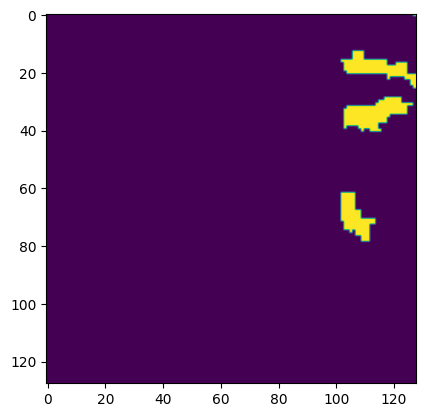

In [8]:
with h5py.File(path_single_mask) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('mask'))
    print("input data shape:", data.shape)
    plt.imshow(data)

In [9]:
# Split data
x_train, x_valid, y_train, y_valid = train_test_split(TRAIN_XX, TRAIN_YY, test_size=0.2, shuffle=True)

# Release memory
del TRAIN_XX
del TRAIN_YY
del all_train
del all_mask


In [10]:
# Metrics
def recall_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    return K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_true, 0, 1))) + K.epsilon())

def precision_m(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    return K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) / (K.sum(K.round(K.clip(y_pred, 0, 1))) + K.epsilon())

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [11]:
def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator

In [12]:
def unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

    # Contracting path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expanding path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    # Compile model
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=dice_loss, metrics=['accuracy',f1_m, precision_m, recall_m])

    return model


In [13]:
model = unet_model(128, 128, 6)
checkpoint = tf.keras.callbacks.ModelCheckpoint("Model.h5",monitor="f1_score",verbose = 1,save_best_only=True,mode = "max")

history = model.fit(
    x_train, y_train,
    batch_size=16,
    epochs=200,
    verbose = 2,
    validation_data=(x_valid, y_valid),
    callbacks=checkpoint
)
model.save("Model_save.h5")


Epoch 1/200
190/190 - 104s - loss: 0.9414 - accuracy: 0.8973 - f1_m: 0.0518 - precision_m: 0.0267 - recall_m: 0.9996 - val_loss: 0.9384 - val_accuracy: 0.9580 - val_f1_m: 0.0488 - val_precision_m: 0.0252 - val_recall_m: 1.0000 - 104s/epoch - 547ms/step
Epoch 2/200
190/190 - 108s - loss: 0.9395 - accuracy: 0.9406 - f1_m: 0.0895 - precision_m: 0.0476 - recall_m: 0.9977 - val_loss: 0.9379 - val_accuracy: 0.9413 - val_f1_m: 0.1305 - val_precision_m: 0.0708 - val_recall_m: 0.9965 - 108s/epoch - 571ms/step
Epoch 3/200
190/190 - 120s - loss: 0.9393 - accuracy: 0.9406 - f1_m: 0.1361 - precision_m: 0.0742 - recall_m: 0.9928 - val_loss: 0.9381 - val_accuracy: 0.9244 - val_f1_m: 0.1419 - val_precision_m: 0.0775 - val_recall_m: 0.9960 - 120s/epoch - 633ms/step
Epoch 4/200
190/190 - 120s - loss: 0.9393 - accuracy: 0.9437 - f1_m: 0.1623 - precision_m: 0.0898 - recall_m: 0.9910 - val_loss: 0.9379 - val_accuracy: 0.9435 - val_f1_m: 0.1713 - val_precision_m: 0.0954 - val_recall_m: 0.9886 - 120s/epoch -

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


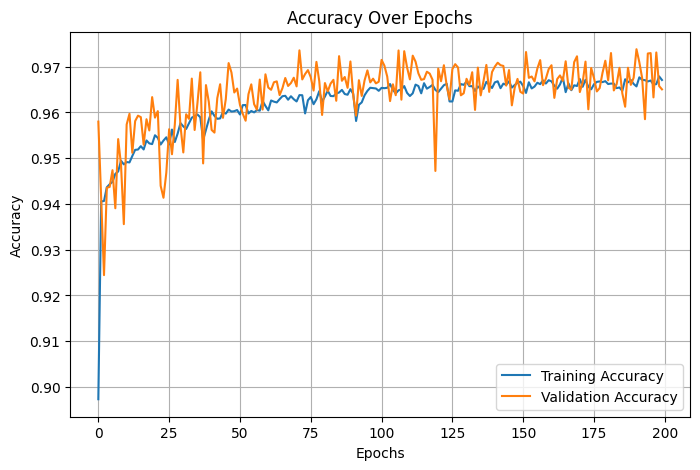

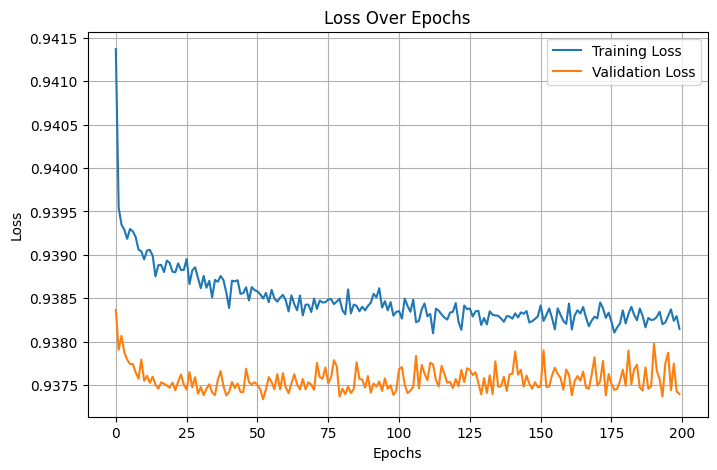

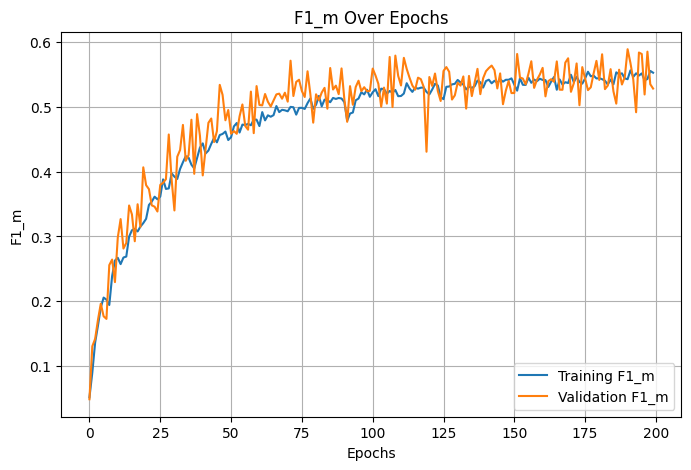

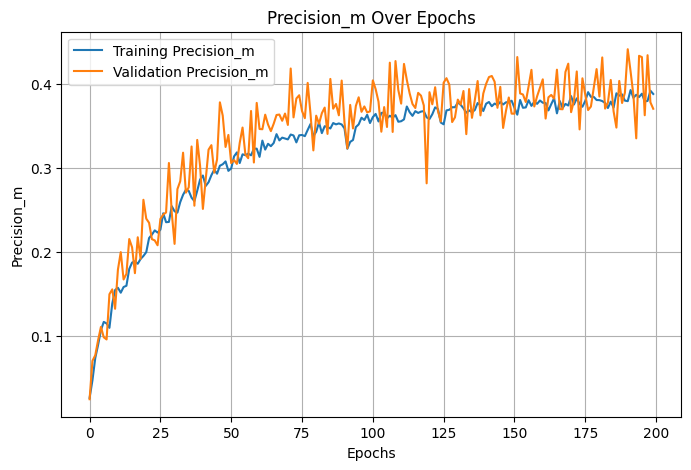

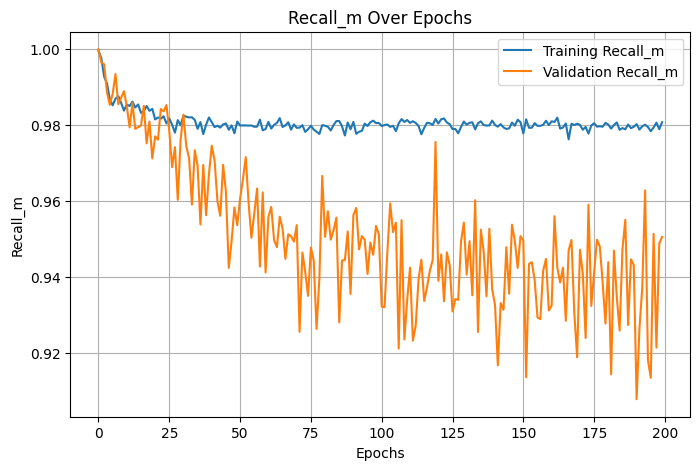

In [14]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics
def plot_metrics(history):
    metrics = ['accuracy', 'loss', 'f1_m', 'precision_m', 'recall_m']
    for metric in metrics:
        plt.figure(figsize=(8, 5))
        plt.plot(history.history[f'{metric}'], label=f'Training {metric.capitalize()}')
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric.capitalize()}')
        plt.title(f'{metric.capitalize()} Over Epochs')
        plt.xlabel('Epochs')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.show()

# Call the function
plot_metrics(history)

1/1 [==============================] - 0s 451ms/step


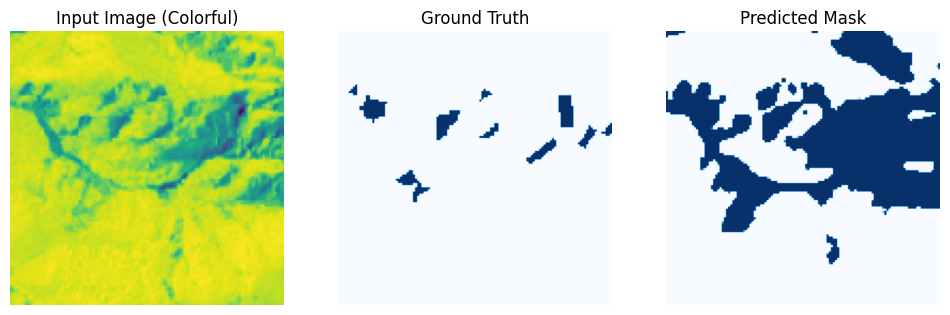

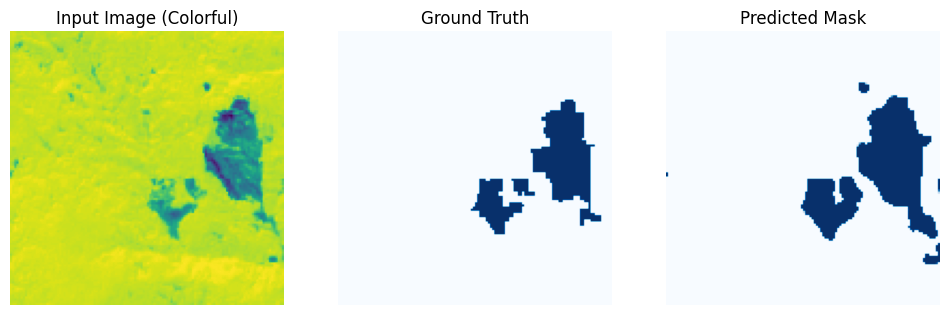

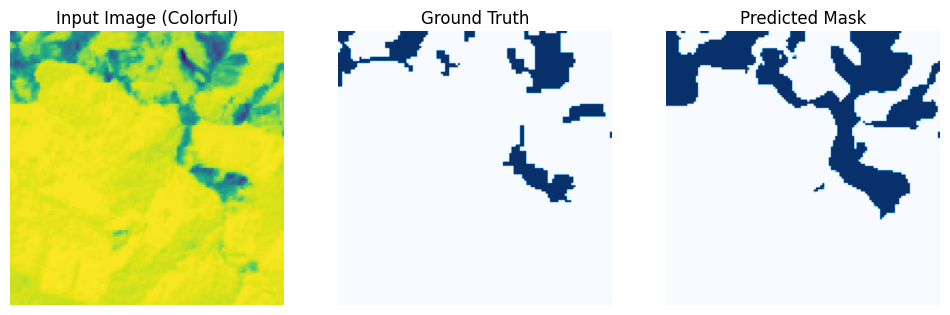

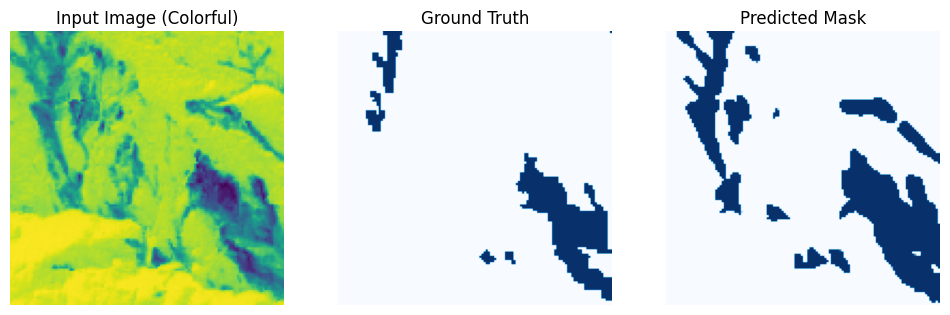

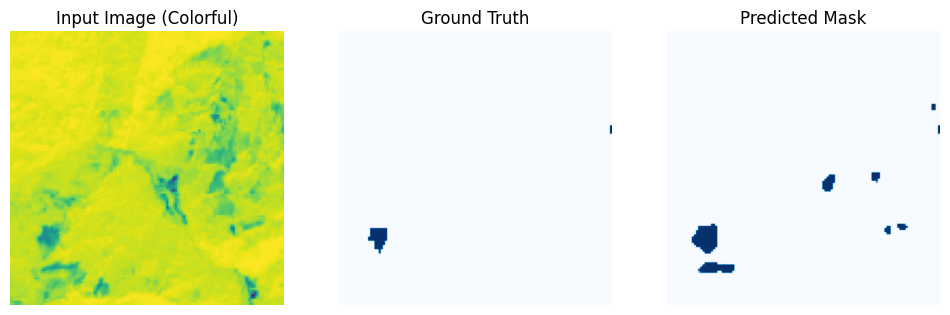

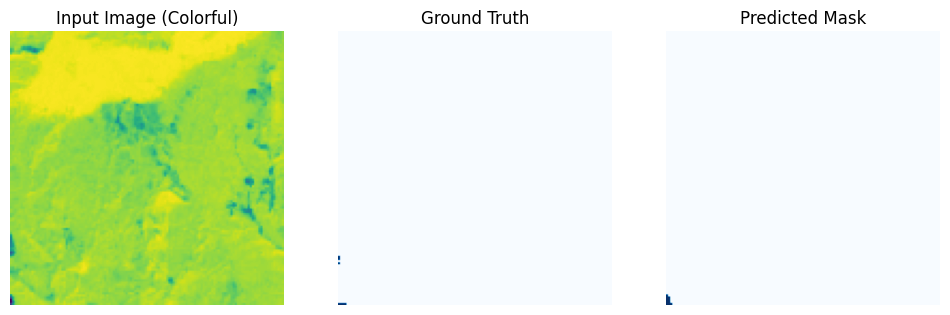

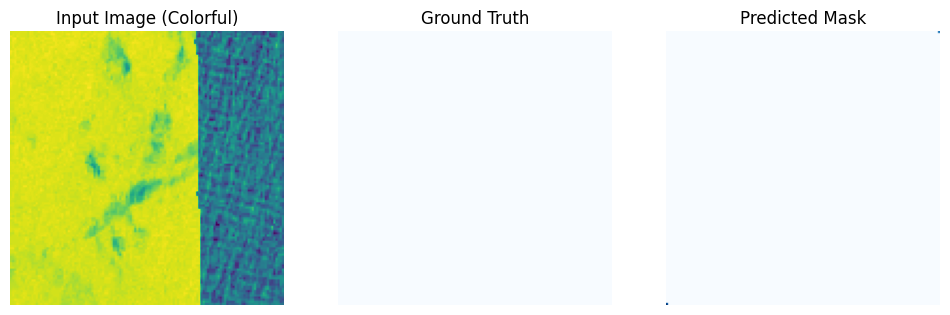

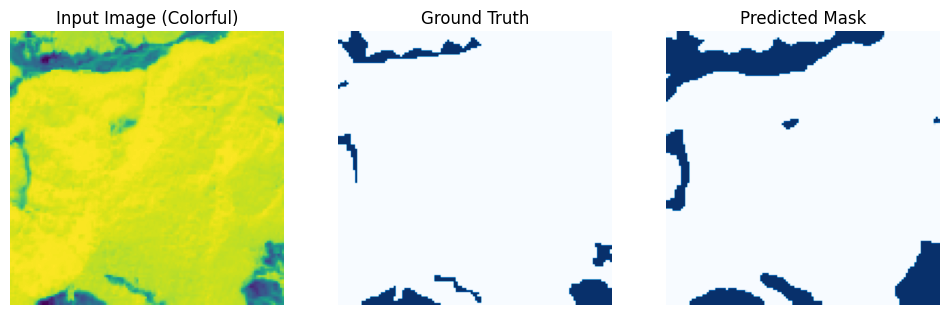

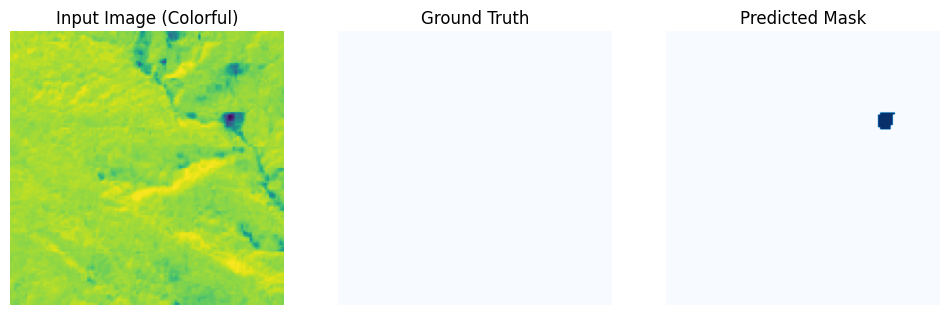

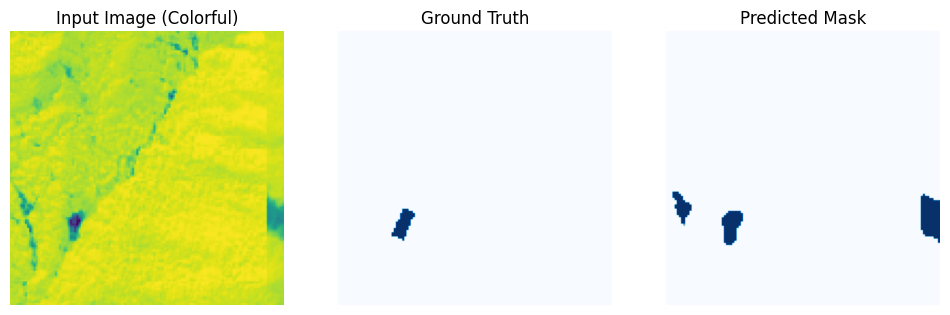

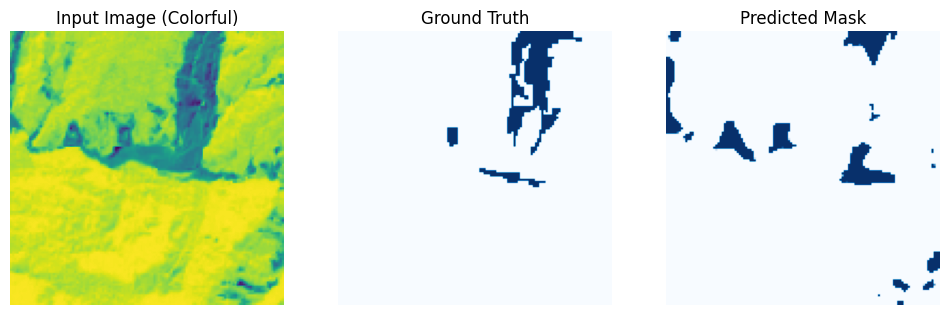

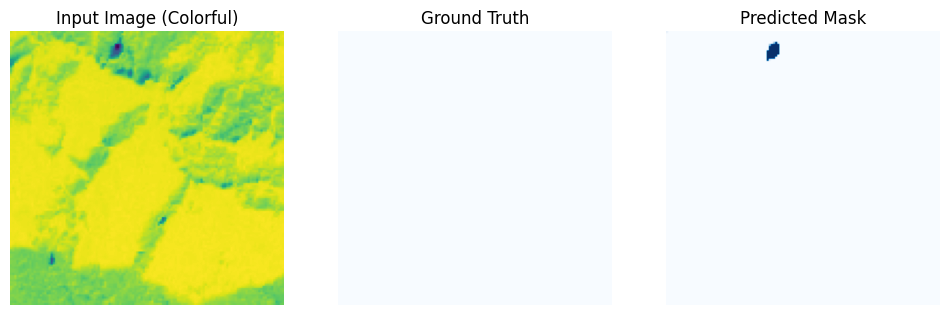

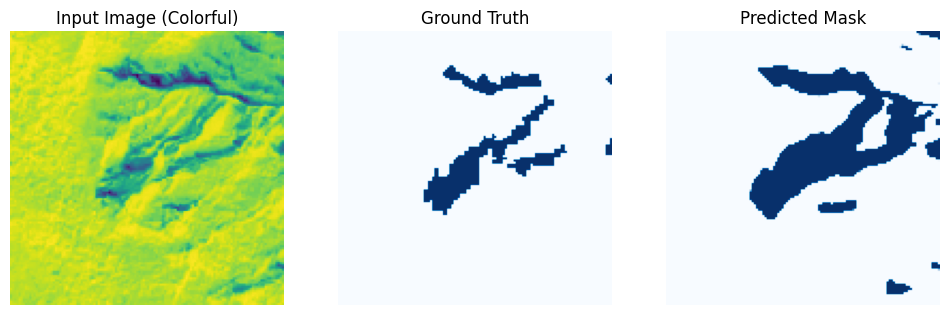

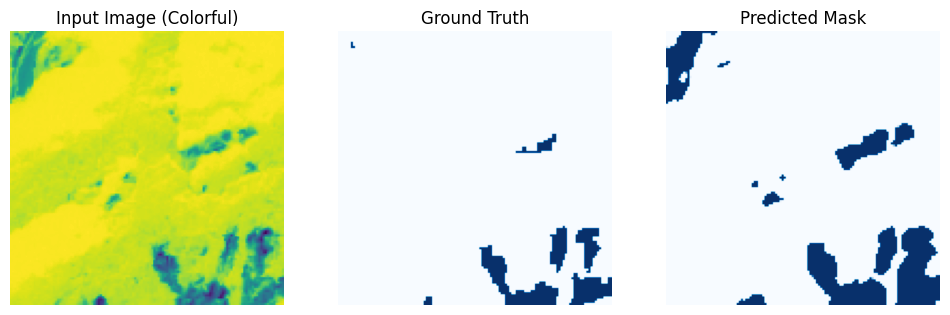

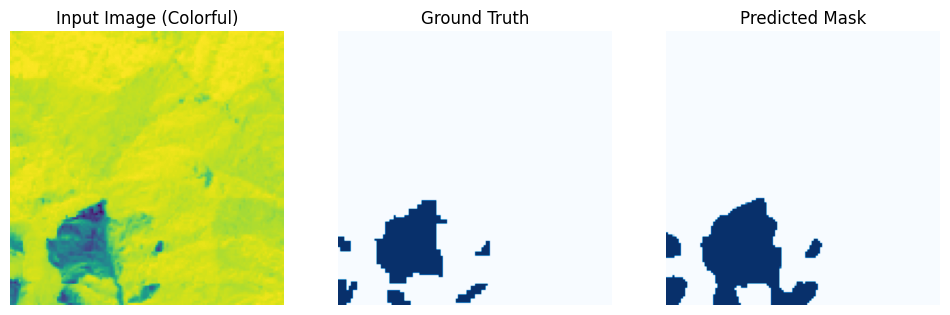

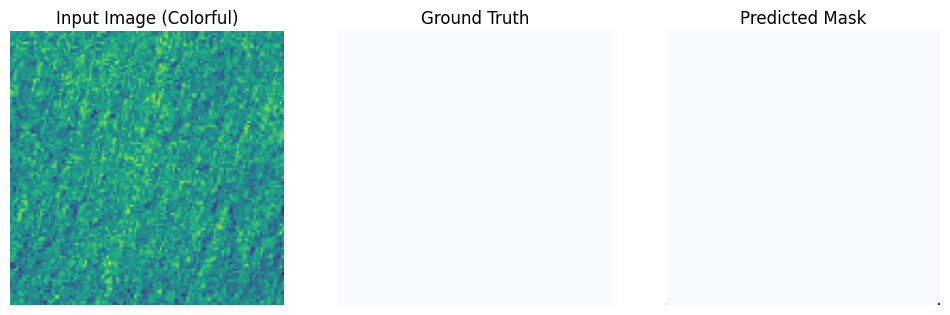

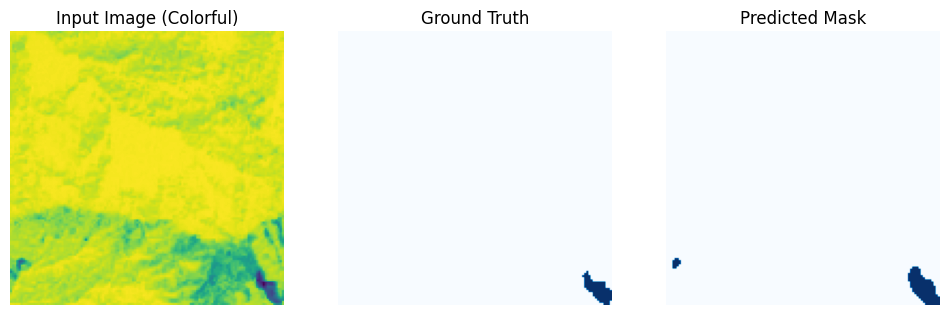

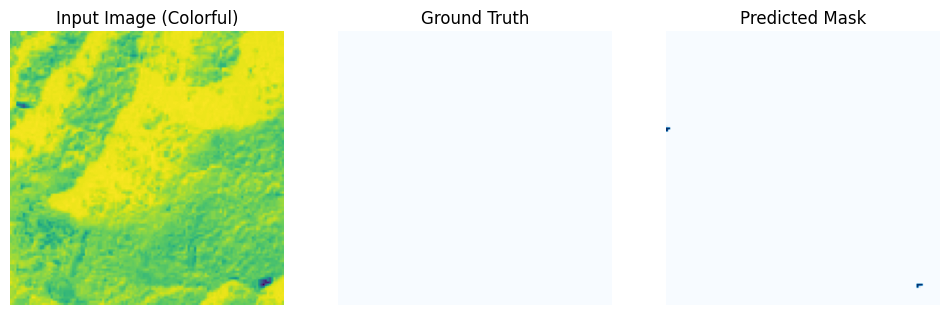

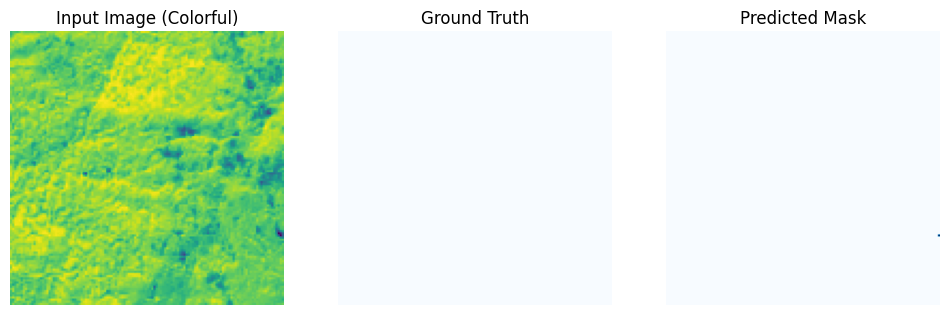

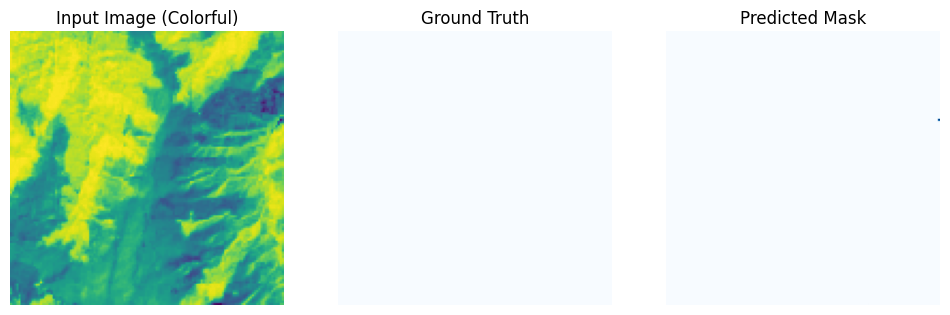

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_predictions(model, x_data, y_true, num_samples=3):
    """
    Visualize input images, ground truth labels, and model predictions with colorful input images.
    """
    # Get predictions from the model
    predictions = model.predict(x_data[:num_samples])
    
    for i in range(num_samples):
        plt.figure(figsize=(12, 4))
        
        # Input Image (using 'viridis' for colorful visualization)
        plt.subplot(1, 3, 1)
        plt.imshow(x_data[i, ..., 0], cmap='viridis')  # Use a vibrant colormap
        plt.title("Input Image (Colorful)")
        plt.axis('off')
        
        # Ground Truth Label (using 'Greens' for labels)
        plt.subplot(1, 3, 2)
        plt.imshow(y_true[i].squeeze(), cmap='Blues')  # Green colormap for labels
        plt.title("Ground Truth")
        plt.axis('off')
        
        # Predicted Mask (using 'Blues' for predictions)
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i].squeeze(), cmap='Blues')  # Blue colormap for predictions
        plt.title("Predicted Mask")
        plt.axis('off')
        
        plt.show()

# Call the visualization function
visualize_predictions(model, x_valid, y_valid, num_samples=20)


In [16]:
def get_metrics(history):
    """
    Extract and return training and validation metrics from the model's history.
    
    Args:
        history: History object returned by model.fit().
    
    Returns:
        A dictionary containing training and validation metrics:
        - Accuracy
        - Loss
        - F1 score
        - Precision
        - Recall
    """
    metrics = {
        "Training Accuracy": history.history.get('accuracy', []),
        "Validation Accuracy": history.history.get('val_accuracy', []),
        "Training Loss": history.history.get('loss', []),
        "Validation Loss": history.history.get('val_loss', []),
        "Training F1 Score": history.history.get('f1_m', []),
        "Validation F1 Score": history.history.get('val_f1_m', []),
        "Training Precision": history.history.get('precision_m', []),
        "Validation Precision": history.history.get('val_precision_m', []),
        "Training Recall": history.history.get('recall_m', []),
        "Validation Recall": history.history.get('val_recall_m', []),
    }
    return metrics

# Example Usage:
metrics = get_metrics(history)

# Print Metrics
for key, value in metrics.items():
    print(f"{key}: {value[-1] if value else 'Not available'}")  # Print the last epoch's value


Training Accuracy: 0.9670969843864441
Validation Accuracy: 0.9650506377220154
Training Loss: 0.9381466507911682
Validation Loss: 0.937396228313446
Training F1 Score: 0.5526291131973267
Validation F1 Score: 0.5281742215156555
Training Precision: 0.38843709230422974
Validation Precision: 0.37082400918006897
Training Recall: 0.9807531833648682
Validation Recall: 0.950498104095459
